<a href="https://colab.research.google.com/github/Francescolaz/AlgorithmsMassiveDatasets-project/blob/main/AMD_Project_GITHUB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMD - Project 2020/21

## Francesco Lazzara 942830

“I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study.“

# Dowload the dataset from Kaggle API 

URL-link to the dataset: <https://www.kaggle.com/ashirwadsangwan/imdb-dataset?select=title.basics.tsv.gz​>

In [1]:
 # Install the "kaggle" library to establish the connection with the Kaggle API

!pip install -q kaggle

# Upload the "kaggle.json" file with the credentials for the Kaggle API

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"francescolaz","key":"e4e7aedec77147b9f0dea02fb3216c54"}'}

In [2]:
# Copy the Kaggle API token "kaggle.json" in the .kaggle folder (Google Drive)

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
# Mount Google Drive to use the storage space for downloading the dataset

from google.colab import drive


# Follow the URL-link to get the authorization code to connect Google Drive with Colab and use it as storage

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
 # Change the permissions of the file
 
 !chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Paste the Kaggle API command to download the IMDb dataset

!kaggle datasets download -d ashirwadsangwan/imdb-dataset

100% 1.44G/1.44G [00:21<00:00, 85.0MB/s]
100% 1.44G/1.44G [00:21<00:00, 72.6MB/s]


In [6]:
# Check the files contained in the workind directory

!ls

drive  imdb-dataset.zip  kaggle.json  sample_data


In [7]:
# Unzip the "imdb-dataset" and delete the zip file

!unzip \*.zip  && rm *.zip

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


## Install Spark

We would try to extract only the actor/actress observations from the "title.principals.ts" table, along with the "*tconst* and "*nconst*" columns to link the actors to their name ("nconst") and movies ("tconst").

In [8]:
# Install Java
# Install Spark (change the version number according to: https://downloads.apache.org/spark/)
# Unzip the Spark file to the current folder
# Install Findspark using pip

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [9]:
# Set the Spark folder to the system path environment

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
import findspark

# Locate Spark in the system

findspark.init()
findspark.find()

'/content/spark-3.0.3-bin-hadoop2.7'

In [10]:
# Start a Spark session

from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .config("spark.driver.memory", "15g")\
        .getOrCreate()

In [11]:
print(spark, type(spark))

<pyspark.sql.session.SparkSession object at 0x7f0ab6981610> <class 'pyspark.sql.session.SparkSession'>


In [12]:
# The SparkContext represents the connection to a Spark cluster and can be used to create RDD and broadcast variables

from pyspark import SparkContext

sc = spark.sparkContext

## Data Pre-processing

---



In [13]:
# Inspect the "tsv" files where the Movie titles are stored

titles = spark.read.csv("/content/title.basics.tsv/title.basics.tsv", 
               sep=r'\t', header=True).select("tconst", "titleType", "PrimaryTitle", "originalTitle", "genres")

print(titles.count())

6321302


In [14]:
# Inspect if there are nan values - TITLES

from pyspark.sql.functions import isnan

for clm in titles.columns:
    print("Count of Nan for '{}': ".format(clm) + str(titles.filter(isnan(titles[clm])).count()))

Count of Nan for 'tconst': 0
Count of Nan for 'titleType': 0
Count of Nan for 'PrimaryTitle': 7
Count of Nan for 'originalTitle': 7
Count of Nan for 'genres': 0


In [15]:
# Remove the null values from the dataset

titles = titles.filter("PrimaryTitle != 'Nan'")

titles.head(10)

[Row(tconst='tt0000001', titleType='short', PrimaryTitle='Carmencita', originalTitle='Carmencita', genres='Documentary,Short'),
 Row(tconst='tt0000002', titleType='short', PrimaryTitle='Le clown et ses chiens', originalTitle='Le clown et ses chiens', genres='Animation,Short'),
 Row(tconst='tt0000003', titleType='short', PrimaryTitle='Pauvre Pierrot', originalTitle='Pauvre Pierrot', genres='Animation,Comedy,Romance'),
 Row(tconst='tt0000004', titleType='short', PrimaryTitle='Un bon bock', originalTitle='Un bon bock', genres='Animation,Short'),
 Row(tconst='tt0000005', titleType='short', PrimaryTitle='Blacksmith Scene', originalTitle='Blacksmith Scene', genres='Comedy,Short'),
 Row(tconst='tt0000006', titleType='short', PrimaryTitle='Chinese Opium Den', originalTitle='Chinese Opium Den', genres='Short'),
 Row(tconst='tt0000007', titleType='short', PrimaryTitle='Corbett and Courtney Before the Kinetograph', originalTitle='Corbett and Courtney Before the Kinetograph', genres='Short,Sport')

In [16]:
# Inspect the "tsv" files where the Individual job's (for each movie)

job = spark.read.csv("/content/title.principals.tsv/title.principals.tsv", 
                    sep=r'\t', header=True).select("tconst", "ordering", "nconst", "category")

print(job.count())

36468817


In [17]:
# Inspect if there are null values - JOB

for clm in job.columns:
    print("Count of Nan for '{}': ".format(clm) + str(job.filter(isnan(job[clm])).count()))

Count of Nan for 'tconst': 0
Count of Nan for 'ordering': 0
Count of Nan for 'nconst': 0
Count of Nan for 'category': 0


In [18]:
job.head(10)

[Row(tconst='tt0000001', ordering='1', nconst='nm1588970', category='self'),
 Row(tconst='tt0000001', ordering='2', nconst='nm0005690', category='director'),
 Row(tconst='tt0000001', ordering='3', nconst='nm0374658', category='cinematographer'),
 Row(tconst='tt0000002', ordering='1', nconst='nm0721526', category='director'),
 Row(tconst='tt0000002', ordering='2', nconst='nm1335271', category='composer'),
 Row(tconst='tt0000003', ordering='1', nconst='nm0721526', category='director'),
 Row(tconst='tt0000003', ordering='2', nconst='nm5442194', category='producer'),
 Row(tconst='tt0000003', ordering='3', nconst='nm1335271', category='composer'),
 Row(tconst='tt0000003', ordering='4', nconst='nm5442200', category='editor'),
 Row(tconst='tt0000004', ordering='1', nconst='nm0721526', category='director')]

In [19]:
# Inspect the "tsv" files where the Actor name's are stored (for each job)

actors = spark.read.csv("/content/name.basics.tsv/name.basics.tsv", 
               sep=r'\t', header=True).select("nconst", "primaryName", "birthYear", "deathYear", "knownForTitles")

print(actors.count())

9706922


In [20]:
# Inspect if there are null values - ACTORS

for clm in actors.columns:
    print("Count of Nan for '{}': ".format(clm) + str(actors.filter(isnan(actors[clm])).count()))

Count of Nan for 'nconst': 0
Count of Nan for 'primaryName': 7
Count of Nan for 'birthYear': 0
Count of Nan for 'deathYear': 0
Count of Nan for 'knownForTitles': 0


In [21]:
# Remove the null values from the dataset

actors = actors.filter("primaryName != 'Nan'")

actors.head(10)

[Row(nconst='nm0000001', primaryName='Fred Astaire', birthYear='1899', deathYear='1987', knownForTitles='tt0050419,tt0053137,tt0072308,tt0043044'),
 Row(nconst='nm0000002', primaryName='Lauren Bacall', birthYear='1924', deathYear='2014', knownForTitles='tt0071877,tt0117057,tt0038355,tt0037382'),
 Row(nconst='nm0000003', primaryName='Brigitte Bardot', birthYear='1934', deathYear='\\N', knownForTitles='tt0054452,tt0049189,tt0059956,tt0057345'),
 Row(nconst='nm0000004', primaryName='John Belushi', birthYear='1949', deathYear='1982', knownForTitles='tt0077975,tt0072562,tt0080455,tt0078723'),
 Row(nconst='nm0000005', primaryName='Ingmar Bergman', birthYear='1918', deathYear='2007', knownForTitles='tt0069467,tt0050976,tt0083922,tt0050986'),
 Row(nconst='nm0000006', primaryName='Ingrid Bergman', birthYear='1915', deathYear='1982', knownForTitles='tt0038109,tt0036855,tt0077711,tt0038787'),
 Row(nconst='nm0000007', primaryName='Humphrey Bogart', birthYear='1899', deathYear='1957', knownForTitle

In [22]:
# Extract the list of movies from the titles DataFrame

print('Number of movies in the Dataset: {}\n'.format(titles.filter(titles.titleType == "movie").select("tconst", "titleType", "primaryTitle") \
            .rdd.map(lambda row : row[:3]).count()))

(titles.filter(titles.titleType == "movie").select("tconst", "titleType", "primaryTitle") \
            .rdd.map(lambda row : row[:3]).take(100))

Number of movies in the Dataset: 536032



[('tt0000009', 'movie', 'Miss Jerry'),
 ('tt0000147', 'movie', 'The Corbett-Fitzsimmons Fight'),
 ('tt0000335', 'movie', 'Soldiers of the Cross'),
 ('tt0000502', 'movie', 'Bohemios'),
 ('tt0000574', 'movie', 'The Story of the Kelly Gang'),
 ('tt0000615', 'movie', 'Robbery Under Arms'),
 ('tt0000630', 'movie', 'Hamlet'),
 ('tt0000675', 'movie', 'Don Quijote'),
 ('tt0000676', 'movie', 'Don Álvaro o la fuerza del sino'),
 ('tt0000679', 'movie', 'The Fairylogue and Radio-Plays'),
 ('tt0000739', 'movie', 'El pastorcito de Torrente'),
 ('tt0000793', 'movie', 'Andreas Hofer'),
 ('tt0000812', 'movie', 'El blocao Velarde'),
 ('tt0000814', 'movie', 'La bocana de Mar Chica'),
 ('tt0000838', 'movie', 'A Cultura do Cacau'),
 ('tt0000842', 'movie', 'De Garraf a Barcelona'),
 ('tt0000846', 'movie', 'Un día en Xochimilco'),
 ('tt0000850', 'movie', 'Los dos hermanos'),
 ('tt0000859', 'movie', 'Fabricación del corcho en Sant Feliu de Guixols'),
 ('tt0000862', 'movie', 'Faldgruben'),
 ('tt0000867', 'movi

In [23]:
# Create a DataFrame with information about the actors and movies

df_actors = job.filter((job.category == "actor") | (job.category == "actress")).select("tconst", "nconst", "category")

# Get the name of the actors for each movie played (with repetitions)

df_actors = df_actors.join(actors, df_actors.nconst == actors.nconst) \
                     .select(df_actors.tconst, df_actors.nconst, "primaryName", "category")

# Retrieve from "titles" only the movies as tytleType, not including tvseries (Episode #1.x)

only_movies = titles.filter(titles.titleType == "movie").select("tconst", "titleType", "primaryTitle")

# Connect each actor with the movies he/she played in

df_actors = df_actors.join(only_movies, df_actors.tconst == only_movies.tconst) \
                     .select(df_actors.tconst, df_actors.nconst, "primaryName", "category", "titleType", "primaryTitle")

print(df_actors.count())

1692933


In [24]:
df_actors.show(100)

+---------+---------+--------------------+--------+---------+--------------------+
|   tconst|   nconst|         primaryName|category|titleType|        primaryTitle|
+---------+---------+--------------------+--------+---------+--------------------+
|tt0002591|nm0509573|       Harry Liedtke|   actor|    movie|             Zu spät|
|tt0002591|nm0029806|Martha Angerstein...| actress|    movie|             Zu spät|
|tt0003689|nm0585503| George W. Middleton|   actor|    movie|          Born Again|
|tt0003689|nm0694718|      Beulah Poynter| actress|    movie|          Born Again|
|tt0003689|nm0101071|         John Bowers|   actor|    movie|          Born Again|
|tt0003689|nm0910564|      Mrs. E. Walton| actress|    movie|          Born Again|
|tt0003689|nm0527801|        Octave Luzon|   actor|    movie|          Born Again|
|tt0003689|nm0399988|       Wilbur Hudson|   actor|    movie|          Born Again|
|tt0003689|nm0728289|   William S. Rising|   actor|    movie|          Born Again|
|tt0

In [25]:
# Look a the number of actors for each movie

from pyspark.sql.functions import desc

df_actors.groupBy("primaryTitle").count().sort(desc("count")).head(10)

[Row(primaryTitle='Hamlet', count=145),
 Row(primaryTitle='Macbeth', count=140),
 Row(primaryTitle='Honeymoon', count=139),
 Row(primaryTitle='Broken', count=131),
 Row(primaryTitle='Alone', count=128),
 Row(primaryTitle='Love', count=127),
 Row(primaryTitle='Desire', count=125),
 Row(primaryTitle='Mother', count=123),
 Row(primaryTitle='Homecoming', count=117),
 Row(primaryTitle='Revenge', count=115)]

---

## Project 2: Market-basket analysis

The task is to implement a system finding frequent itemsets (aka market-basket analysis), analyzing one of the two datasets described below.
IMDB
The «​IMDB​» dataset is published on Kaggle, under I​MDB non-commercial licensing​. The analysis must be done considering movies as baskets and actors as items.

In general, we only need small frequent itemsets with *k* that nevers grows beyond 2 or 3 (subset size).

In [26]:
# Create baskets (movies) with items (actors)
# List of items for each each basket [[item1, item2, ...], ..., []]

from pyspark.sql import functions as F

baskets_list = (df_actors.groupby("primaryTitle").agg(F.collect_list("primaryName")).rdd.map(lambda row: row[1]).collect())

print(len(baskets_list))

346874


In [27]:
baskets_list[:10]

[['Tôru Mito',
  'Naomi Oka',
  'Haruo Aozora',
  'Reiko Maki',
  'Chizuyu Azami',
  'Kyôko Kanô'],
 ['Robin Nedwell', 'Trevor Howard', 'Diane Keen', 'Jack Douglas'],
 ['Frank Wuttig', 'Angelika Herrmann', 'Lilo Josefowitz', 'Ralf Schlösser'],
 ['Monique Cooper', 'Gene Minero', 'Kelsey Bohlen', 'Alisha Seaton'],
 ['Bhama', 'Meghana Raj', 'Arun', 'Shweta Menon', 'Mithun Ramesh'],
 ['Irina Byakova',
  'Natalya Gundareva',
  'Sergey Gazarov',
  'Oksana Mysina',
  'Sergey Gabrielyan'],
 ['Pug', 'Coco', 'Steven', 'Funmi Sodipo'],
 ['George J. Lewis', 'Alice Joyce', 'Jean Hersholt', 'Zasu Pitts'],
 ['Mahamadou Alzouma', 'Rachid Abeghraz', 'Aminata Kanta', 'Adoum Moussa'],
 ['Alejandro Hirschfeld', 'Fera Szmuc', 'Natalia Herrero', 'Hernán Melgarejo']]

## A-Priori algorithm

It is designed to reduce the number of pairs that must be counted, at the expense of performing two passes over the data.

In [28]:
# Get the unique name of actors in the list of baskets and hash each distinct item to an integer number (from 0 to n)

items_to_hash = dict(enumerate(sc.parallelize(baskets_list).flatMap(lambda bask: bask).distinct().collect(), 0))

print(len(items_to_hash))

560653


In [29]:
# Alternative dictionary with items as keys and hash as values

key_actors = dict(zip(items_to_hash.values(), items_to_hash.keys()))

print(len(key_actors))

560653


In [30]:
# Hash table (DataFrame format)

spark.createDataFrame(items_to_hash.items(), schema = ["Hash", "Item"]).show(100)

+----+--------------------+
|Hash|                Item|
+----+--------------------+
|   0|           Tôru Mito|
|   1|           Naomi Oka|
|   2|        Haruo Aozora|
|   3|          Reiko Maki|
|   4|       Chizuyu Azami|
|   5|          Kyôko Kanô|
|   6|       Robin Nedwell|
|   7|       Trevor Howard|
|   8|          Diane Keen|
|   9|        Jack Douglas|
|  10|        Frank Wuttig|
|  11|   Angelika Herrmann|
|  12|     Lilo Josefowitz|
|  13|      Ralf Schlösser|
|  14|      Monique Cooper|
|  15|         Gene Minero|
|  16|       Kelsey Bohlen|
|  17|       Alisha Seaton|
|  18|               Bhama|
|  19|         Meghana Raj|
|  20|                Arun|
|  21|        Shweta Menon|
|  22|       Mithun Ramesh|
|  23|       Irina Byakova|
|  24|   Natalya Gundareva|
|  25|      Sergey Gazarov|
|  26|       Oksana Mysina|
|  27|   Sergey Gabrielyan|
|  28|                 Pug|
|  29|                Coco|
|  30|              Steven|
|  31|        Funmi Sodipo|
|  32|     George J.

In [31]:
# Format the list of baskets with actors to baskets with hash of actors

baskets_hash = (sc.parallelize(baskets_list)
                  .map(lambda basket: [key_actors[item] for item in basket])
                  .collect())

baskets_hash[:100]

[[0, 1, 2, 3, 4, 5],
 [6, 7, 8, 9],
 [10, 11, 12, 13],
 [14, 15, 16, 17],
 [18, 19, 20, 21, 22],
 [23, 24, 25, 26, 27],
 [28, 29, 30, 31],
 [32, 33, 34, 35],
 [36, 37, 38, 39],
 [40, 41, 42, 43],
 [44],
 [45, 46, 47, 48, 49, 50, 51],
 [52, 53],
 [54, 55, 56, 57],
 [58, 59, 60, 61],
 [62, 63, 64, 65, 66, 67, 68, 69],
 [70, 71, 72, 73],
 [74, 75, 76, 77],
 [78, 79, 80, 81],
 [82, 83, 84, 85],
 [86, 87, 88, 89],
 [90, 91],
 [92, 93],
 [94, 95, 96, 97],
 [98, 99, 100, 101],
 [102, 103, 104, 105],
 [106, 107, 108, 109],
 [110, 111, 112, 113],
 [114, 115, 116, 117, 118, 119],
 [120, 121, 122, 123],
 [124, 125, 126, 127],
 [128, 129, 130, 131, 132],
 [133, 134, 135, 136],
 [137, 138, 139, 140, 141, 142],
 [143, 144, 145, 146],
 [147, 148, 149, 150, 151, 152],
 [153, 154, 155, 156],
 [157, 158, 159, 160],
 [161],
 [162, 163],
 [164, 165, 166, 167],
 [168, 169, 170, 171],
 [172, 173, 174, 175],
 [176, 177, 178, 179],
 [180, 181, 182],
 [183, 184, 185, 186],
 [187],
 [188, 189, 190, 191, 192, 19

In [32]:
# Count the occurrence of each item over all the baskets

array_counts = sorted((sc.parallelize(baskets_list).flatMap(lambda basket: [(key_actors[item], 1) for item in basket])
                             .reduceByKey(lambda a, b: a + b)
                             .collect()), key=lambda a: a[0], reverse=False) # key=lambda a: a[1], reverse=True for the order based on the counts

print(len(array_counts))

560653


In [33]:
array_counts[:100]

[(0, 1),
 (1, 77),
 (2, 6),
 (3, 15),
 (4, 19),
 (5, 9),
 (6, 2),
 (7, 63),
 (8, 2),
 (9, 5),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 10),
 (17, 16),
 (18, 33),
 (19, 23),
 (20, 54),
 (21, 43),
 (22, 2),
 (23, 4),
 (24, 30),
 (25, 27),
 (26, 4),
 (27, 5),
 (28, 1),
 (29, 3),
 (30, 1),
 (31, 1),
 (32, 37),
 (33, 53),
 (34, 78),
 (35, 106),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 6),
 (45, 5),
 (46, 126),
 (47, 6),
 (48, 73),
 (49, 51),
 (50, 4),
 (51, 44),
 (52, 9),
 (53, 6),
 (54, 26),
 (55, 15),
 (56, 15),
 (57, 36),
 (58, 75),
 (59, 52),
 (60, 26),
 (61, 18),
 (62, 9),
 (63, 15),
 (64, 4),
 (65, 5),
 (66, 24),
 (67, 7),
 (68, 10),
 (69, 22),
 (70, 2),
 (71, 41),
 (72, 10),
 (73, 5),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 2),
 (78, 58),
 (79, 2),
 (80, 40),
 (81, 1),
 (82, 34),
 (83, 2),
 (84, 2),
 (85, 8),
 (86, 2),
 (87, 20),
 (88, 8),
 (89, 14),
 (90, 5),
 (91, 4),
 (92, 1),
 (93, 8),
 (94, 72),
 (95, 30),
 (96, 1

In [34]:
# Format the frequent triples from items to actors names

actors_counts = sorted((sc.parallelize(array_counts)
                          .map(lambda basket: ((items_to_hash[basket[0]], basket[1])))
                          .collect()), key=lambda a: a[1], reverse = True)

print(len(actors_counts))

560653


In [35]:
actors_counts[:10]

[('Brahmanandam', 798),
 ('Adoor Bhasi', 585),
 ('Matsunosuke Onoe', 565),
 ('Eddie Garcia', 507),
 ('Prem Nazir', 438),
 ('Sung-il Shin', 411),
 ('Paquito Diaz', 391),
 ('Masayoshi Nogami', 387),
 ('Mammootty', 381),
 ('Aachi Manorama', 355)]

In [36]:
# Inspect the mean value of movies played by actors/actresses to set the support treshold

print('Mean value of movies played by actors/actresses: {}'.format(round((sc.parallelize(array_counts).map(lambda tup: tup[1]).mean()), 2)))

Mean value of movies played by actors/actresses: 3.02


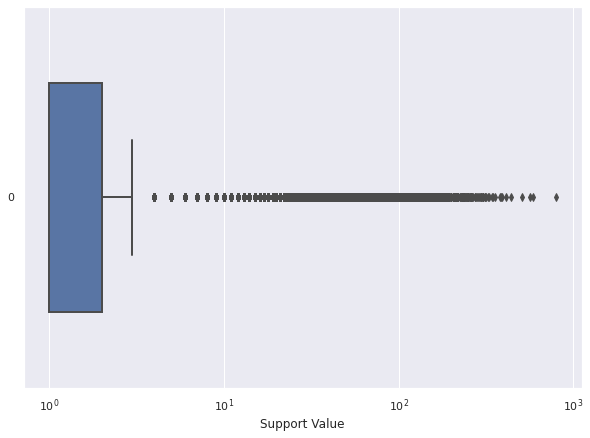

In [37]:
# Boxplot of the distribution of counts in LOG scale to be inspected for setting the support threshold (lot of outliers)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.set(style="darkgrid")
g = sns.boxplot(data=[val[1] for val in array_counts], linewidth=2, width=.6, orient="h")
g.set_xscale("log")
g.set(xlabel="Support Value")
plt.show()

In [38]:
# The 95% percentile corresponds to 10 movies played

import numpy as np

np.percentile([val[1] for val in array_counts], 95)

10.0

In [39]:
# Hashed value of the first-ranked actors for number of movies

key_actors['Brahmanandam']

799

In [40]:
# Average length of each basket

print("The average number of actors in each basket is: {}".format(round((sc.parallelize(baskets_hash))
                                                                           .map(lambda basket: len(basket))
                                                                           .mean(), 2)))

The average number of actors in each basket is: 4.88


In [41]:
# Inspect the average number of actors in the movies played by "Brahmanandam"

Brahmanandam_avgmovies = (sc.parallelize(baskets_hash)
                            .map(lambda basket: len(basket) if 799 in basket else 0)
                            .collect())

print("The average number of actors in the movies played by 'Brahmanandam' is : {}".format(round(np.mean([val for val in Brahmanandam_avgmovies if val != 0]), 2)))

The average number of actors in the movies played by 'Brahmanandam' is : 6.12


In [42]:
# Frequent-items table of length "m"
# entry i-th is -1 if item "i" is not frequent, while its proper ID if the item "i" is frequent

freqitem_table = (sc.parallelize(array_counts)
                    .map(lambda basket: -1 if basket[1] <= 10 else basket[0])
                    .collect())

freqitem_table[:100]

[-1,
 1,
 -1,
 3,
 4,
 -1,
 -1,
 7,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 17,
 18,
 19,
 20,
 21,
 -1,
 -1,
 24,
 25,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 32,
 33,
 34,
 35,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 46,
 -1,
 48,
 49,
 -1,
 51,
 -1,
 -1,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 -1,
 63,
 -1,
 -1,
 66,
 -1,
 -1,
 69,
 -1,
 71,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 78,
 -1,
 80,
 -1,
 82,
 -1,
 -1,
 -1,
 -1,
 87,
 -1,
 89,
 -1,
 -1,
 -1,
 -1,
 94,
 95,
 96,
 97,
 -1,
 -1]

In [43]:
# Second Pass of A-Priori: count all the pairs that consist of two frequent items
# Inspect the frequent items in each basket (the ones different from -1)

baskets_hash = (sc.parallelize(baskets_hash)
                  .map(lambda basket: [freqitem_table[item] for item in basket])
                  .collect())

# Remove non frequent items in the baskets

baskets_hash = (sc.parallelize(baskets_hash)
                  .map(lambda basket: [item for item in basket if item != -1])
                  .collect())

# Remove the empty baskets and the ones with length lower than 2

baskets_hash = list(filter(lambda bsk: bsk != [] and len(bsk) >= 2, baskets_hash))

print(len(baskets_hash))

181215


In [44]:
baskets_hash[:100]

[[1, 3, 4],
 [18, 19, 20, 21],
 [24, 25],
 [32, 33, 34, 35],
 [46, 48, 49, 51],
 [54, 55, 56, 57],
 [58, 59, 60, 61],
 [63, 66, 69],
 [78, 80],
 [87, 89],
 [94, 95, 96, 97],
 [111, 112],
 [128, 131, 132],
 [134, 135, 136],
 [137, 138, 139, 141, 142],
 [143, 144, 145],
 [153, 154, 156],
 [162, 163],
 [164, 165, 166],
 [176, 177, 178, 179],
 [180, 181],
 [189, 194],
 [205, 206, 207, 208],
 [209, 211],
 [213, 215, 216, 217, 218, 219, 220, 226],
 [231, 232, 233, 234, 235, 236, 237, 238],
 [249, 250, 251, 252],
 [253, 254, 255, 256, 257],
 [258, 259, 260, 261, 262, 263],
 [266, 267, 268],
 [269, 270, 271, 272, 274, 275, 277, 278],
 [280, 281, 282],
 [286, 288],
 [293, 295, 296],
 [309, 310, 311, 312],
 [313, 314, 315, 316],
 [317, 318, 319, 320],
 [323, 324],
 [326, 311, 327, 328],
 [329, 330, 332, 333, 335],
 [341, 342, 343, 345, 346],
 [376, 377, 378],
 [379, 380, 381, 383, 384, 385],
 [386, 388],
 [391, 392, 393, 395, 397],
 [398, 399],
 [400, 401, 403, 404, 405],
 [406, 407, 408, 409, 4

In [45]:
# Generate all pairs of frequent items in each basket

from itertools import combinations

array_counts = (sc.parallelize(baskets_hash)
                  .map(lambda basket: combinations(basket, 2))
                  .flatMap(lambda pairs: [(pair, 1) for pair in pairs])
                  .reduceByKey(lambda a, b: a + b)
                  .collect())

print(len(array_counts))

1118443


In [46]:
array_counts[:100]

[((1, 3), 1),
 ((1, 4), 5),
 ((3, 4), 2),
 ((18, 19), 1),
 ((18, 20), 2),
 ((18, 21), 1),
 ((19, 20), 2),
 ((19, 21), 1),
 ((20, 21), 2),
 ((24, 25), 1),
 ((32, 33), 1),
 ((32, 34), 4),
 ((32, 35), 1),
 ((33, 34), 2),
 ((33, 35), 2),
 ((34, 35), 4),
 ((46, 48), 1),
 ((46, 49), 1),
 ((46, 51), 1),
 ((48, 49), 1),
 ((48, 51), 1),
 ((49, 51), 1),
 ((54, 55), 1),
 ((54, 56), 1),
 ((54, 57), 1),
 ((55, 56), 1),
 ((55, 57), 1),
 ((56, 57), 1),
 ((58, 59), 1),
 ((58, 60), 1),
 ((58, 61), 1),
 ((59, 60), 1),
 ((59, 61), 1),
 ((60, 61), 1),
 ((63, 66), 1),
 ((63, 69), 2),
 ((66, 69), 2),
 ((78, 80), 1),
 ((87, 89), 2),
 ((94, 95), 3),
 ((94, 96), 3),
 ((94, 97), 1),
 ((95, 96), 1),
 ((95, 97), 2),
 ((96, 97), 1),
 ((111, 112), 1),
 ((128, 131), 1),
 ((128, 132), 4),
 ((131, 132), 3),
 ((134, 135), 1),
 ((134, 136), 1),
 ((135, 136), 1),
 ((137, 138), 2),
 ((137, 139), 3),
 ((137, 141), 4),
 ((137, 142), 3),
 ((138, 139), 1),
 ((138, 141), 1),
 ((138, 142), 2),
 ((139, 141), 1),
 ((139, 142), 1)

In [47]:
# Format frequent pairs with items as actor names

actors_counts = sorted((sc.parallelize(array_counts)
                          .map(lambda basket: ((items_to_hash[basket[0][0]], items_to_hash[basket[0][1]]), basket[1]))
                          .collect()), key = lambda a: a[1], reverse = True)

actors_counts[:100]

[(('Adoor Bhasi', 'Prem Nazir'), 237),
 (('Bahadur', 'Adoor Bhasi'), 169),
 (('Kijaku Ôtani', 'Matsunosuke Onoe'), 165),
 (('Jayabharati', 'Adoor Bhasi'), 162),
 (('Kitsuraku Arashi', 'Matsunosuke Onoe'), 136),
 (('Adoor Bhasi', 'Thikkurisi Sukumaran Nair'), 123),
 (('Suminojo Ichikawa', 'Matsunosuke Onoe'), 120),
 (('Kitsuraku Arashi', 'Kijaku Ôtani'), 113),
 (('Jayabharati', 'Bahadur'), 109),
 (('Panchito', 'Dolphy'), 106),
 (("Sen'nosuke Nakamura", 'Matsunosuke Onoe'), 106),
 (('Kijaku Ôtani', 'Suminojo Ichikawa'), 101),
 (('Prem Nazir', 'Thikkurisi Sukumaran Nair'), 101),
 (('Hôshô Bandô', 'Ritoku Arashi'), 99),
 (('Kitsuraku Arashi', 'Suminojo Ichikawa'), 97),
 (('Bahadur', 'Prem Nazir'), 96),
 (('Jayabharati', 'Prem Nazir'), 94),
 (('Adoor Bhasi', 'Paravoor Bharathan'), 92),
 (('Adoor Bhasi', 'Meena'), 90),
 (('Ritoku Arashi', 'Enshô Jitsukawa'), 90),
 (('Madhu', 'Adoor Bhasi'), 90),
 (('Hôshô Bandô', 'Enshô Jitsukawa'), 84),
 (("Sen'nosuke Nakamura", 'Kijaku Ôtani'), 84),
 (('T.

In [48]:
# Frequent-items table of pairs 

freqitem_table = (sc.parallelize(array_counts)
                     .map(lambda basket: -1 if basket[1] <= 10 else basket[0])
                     .collect())

print(len(freqitem_table))

1118443


In [49]:
freqitem_table[:100]

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 (205, 206),
 -1,
 (205, 208),
 (206, 207),
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

In [50]:
# Remove unfrequent pairs

freqitem_table = [freq for freq in freqitem_table if freq != -1]

# Unwind the frequent tuple pairs and extract the distinct items

freqitem_table = sorted(list(set([elem for bsk in freqitem_table for elem in bsk])))

freqitem_table[:100]

[1,
 46,
 78,
 128,
 132,
 134,
 205,
 206,
 207,
 208,
 220,
 233,
 253,
 254,
 255,
 256,
 258,
 261,
 262,
 266,
 268,
 269,
 270,
 271,
 272,
 280,
 281,
 309,
 311,
 312,
 327,
 328,
 335,
 376,
 400,
 403,
 407,
 408,
 409,
 410,
 411,
 414,
 416,
 417,
 418,
 420,
 421,
 423,
 424,
 425,
 462,
 507,
 509,
 510,
 517,
 520,
 538,
 539,
 634,
 664,
 681,
 682,
 684,
 689,
 698,
 699,
 701,
 702,
 703,
 704,
 706,
 711,
 720,
 723,
 737,
 742,
 743,
 744,
 747,
 756,
 757,
 759,
 767,
 768,
 769,
 770,
 775,
 776,
 777,
 795,
 797,
 799,
 807,
 808,
 821,
 822,
 823,
 825,
 826,
 844]

In [51]:
# Format the basket lists to frequent items that appear in frequent pairs

baskets_hash = (sc.parallelize(baskets_hash)
                  .map(lambda basket: [item if item in freqitem_table else -1 for item in basket])
                  .collect())

# Remove non-frequent items and the baskets with length lower than 3

baskets_hash = (sc.parallelize(baskets_hash)
                  .map(lambda basket: [item for item in basket if item != -1])
                  .collect())

baskets_hash = list(filter(lambda bsk: bsk != [] and len(bsk) >= 3, baskets_hash))

baskets_hash[:100]

[[205, 206, 207, 208],
 [253, 254, 255, 256],
 [258, 261, 262],
 [269, 270, 271, 272],
 [309, 311, 312],
 [311, 327, 328],
 [407, 408, 409, 410],
 [411, 414, 416, 417],
 [418, 420, 421, 423, 424, 425],
 [681, 682, 684],
 [702, 703, 704, 706],
 [742, 743, 744, 747],
 [756, 757, 759],
 [767, 768, 769, 770],
 [775, 776, 777],
 [795, 797, 799],
 [821, 822, 823, 825, 826],
 [1075, 1076, 1078, 1082, 1086],
 [1087, 1088, 1089, 1090, 256],
 [1135, 1136, 1137, 1138],
 [1156, 1157, 1158],
 [1167, 1168, 1169],
 [1265, 776, 1267, 1268],
 [1392, 1394, 1395],
 [1530, 1533, 995],
 [1837, 1838, 1839, 1842],
 [1986, 1987, 1988],
 [2074, 2078, 2080, 2083, 2085],
 [2102, 2103, 2105],
 [2126, 2128, 2129, 2130, 2131],
 [1168, 2281, 2282, 2283],
 [424, 2323, 2324, 2325],
 [2368, 2369, 2350],
 [2460, 2461, 2462],
 [2504, 2505, 2506, 2507],
 [821, 2521, 2524],
 [2539, 2540, 2541],
 [2655, 2656, 2657],
 [2713, 2714, 2715],
 [2791, 2794, 2796],
 [2931, 1549, 2932],
 [2975, 2977, 2981],
 [3031, 3032, 3033, 3034]

In [52]:
# Third Pass of A-Priori
# Inspect the frequent triples (among the items that belong to frequent pairs)

array_counts = (sc.parallelize(baskets_hash).map(lambda basket: combinations(basket, 3))
                                            .flatMap(lambda triples: [(triple, 1) for triple in triples])
                                            .reduceByKey(lambda a, b: a + b)
                                            .collect())
print(len(array_counts))

262362


In [53]:
array_counts[:100]

[((205, 206, 207), 4),
 ((205, 206, 208), 4),
 ((205, 207, 208), 1),
 ((206, 207, 208), 1),
 ((253, 254, 255), 3),
 ((253, 254, 256), 2),
 ((253, 255, 256), 5),
 ((254, 255, 256), 4),
 ((258, 261, 262), 1),
 ((269, 270, 271), 1),
 ((269, 270, 272), 2),
 ((269, 271, 272), 2),
 ((270, 271, 272), 7),
 ((309, 311, 312), 1),
 ((311, 327, 328), 3),
 ((407, 408, 409), 13),
 ((407, 408, 410), 14),
 ((407, 409, 410), 13),
 ((408, 409, 410), 28),
 ((411, 414, 416), 1),
 ((411, 414, 417), 1),
 ((411, 416, 417), 1),
 ((414, 416, 417), 2),
 ((418, 420, 421), 2),
 ((418, 420, 423), 2),
 ((418, 420, 424), 1),
 ((418, 420, 425), 1),
 ((418, 421, 423), 5),
 ((418, 421, 424), 5),
 ((418, 421, 425), 3),
 ((418, 423, 424), 3),
 ((418, 423, 425), 2),
 ((418, 424, 425), 2),
 ((420, 421, 423), 3),
 ((420, 421, 424), 1),
 ((420, 421, 425), 1),
 ((420, 423, 424), 1),
 ((420, 423, 425), 1),
 ((420, 424, 425), 1),
 ((421, 423, 424), 7),
 ((421, 423, 425), 1),
 ((421, 424, 425), 5),
 ((423, 424, 425), 1),
 ((681,

In [54]:
# Format the frequent triples from items to actors names

actors_counts = sorted((sc.parallelize(array_counts)
                          .map(lambda basket: ((items_to_hash[basket[0][0]], items_to_hash[basket[0][1]], items_to_hash[basket[0][2]]), basket[1]))
                          .collect()), key = lambda a: a[1], reverse = True)

print(len(actors_counts))

262362


In [55]:
actors_counts[:100]

[(('Kitsuraku Arashi', 'Kijaku Ôtani', 'Matsunosuke Onoe'), 121),
 (('Kijaku Ôtani', 'Suminojo Ichikawa', 'Matsunosuke Onoe'), 106),
 (('Kitsuraku Arashi', 'Suminojo Ichikawa', 'Matsunosuke Onoe'), 101),
 (("Sen'nosuke Nakamura", 'Kijaku Ôtani', 'Matsunosuke Onoe'), 88),
 (('Kitsuraku Arashi', 'Kijaku Ôtani', 'Suminojo Ichikawa'), 87),
 (('Jayabharati', 'Bahadur', 'Adoor Bhasi'), 75),
 (('Kitsuraku Arashi', "Sen'nosuke Nakamura", 'Matsunosuke Onoe'), 75),
 (('Adoor Bhasi', 'Prem Nazir', 'Thikkurisi Sukumaran Nair'), 74),
 (('Hôshô Bandô', 'Ritoku Arashi', 'Enshô Jitsukawa'), 70),
 (("Sen'nosuke Nakamura", 'Suminojo Ichikawa', 'Matsunosuke Onoe'), 68),
 (('Kakumatsuro Arashi', 'Kijaku Ôtani', 'Matsunosuke Onoe'), 63),
 (('Kitsuraku Arashi', "Sen'nosuke Nakamura", 'Kijaku Ôtani'), 63),
 (('Jayabharati', 'Adoor Bhasi', 'Prem Nazir'), 62),
 (('Chosei Kataoka', 'Kijaku Ôtani', 'Matsunosuke Onoe'), 61),
 (('Hôshô Bandô', 'Ritoku Arashi', 'Shôzô Arashi'), 61),
 (('Bahadur', 'Adoor Bhasi', 'Pr

In [56]:
# Frequent-items table of triples

freqitem_table = (sc.parallelize(array_counts)
                     .map(lambda basket: -1 if basket[1] <= 10 else basket[0]) # .map(lambda basket: -1 if basket[1] <= 1 else basket[0])
                     .collect())

len(freqitem_table)

262362

In [57]:
# Remove unfrequent triples

freqitem_table = [freq for freq in freqitem_table if freq != -1]

# Unwind the frequent tuple triples and extract the distinct items

freqitem_table = sorted(list(set([elem for bsk in freqitem_table for elem in bsk])))

print(len(freqitem_table))

436


In [58]:
freqitem_table[:100]

[46,
 256,
 311,
 312,
 327,
 328,
 407,
 408,
 409,
 410,
 421,
 507,
 664,
 701,
 744,
 756,
 797,
 799,
 807,
 869,
 1088,
 1135,
 1157,
 1158,
 1267,
 1530,
 1533,
 1549,
 2126,
 2482,
 2525,
 2689,
 2825,
 2981,
 2986,
 3082,
 3109,
 3111,
 3251,
 3252,
 3253,
 3282,
 3298,
 3314,
 3364,
 3375,
 3427,
 3429,
 3430,
 3631,
 3904,
 4042,
 4045,
 4138,
 4142,
 4161,
 4307,
 4309,
 4488,
 4490,
 4727,
 4729,
 4730,
 4825,
 5202,
 5203,
 5205,
 5207,
 5209,
 5210,
 5211,
 5212,
 5213,
 5230,
 5510,
 5637,
 5638,
 5640,
 5641,
 5642,
 5688,
 5692,
 5693,
 5694,
 5780,
 5781,
 6131,
 6266,
 6267,
 6268,
 6281,
 6283,
 6413,
 6417,
 6641,
 6869,
 6871,
 6983,
 7212,
 7214]

In [59]:
# Format the basket lists to frequent items that appear in frequent pairs

baskets_hash = (sc.parallelize(baskets_hash)
                  .map(lambda basket: [item if item in freqitem_table else -1 for item in basket])
                  .collect())

# Remove non frequent items and empty baskets from the original baskets

baskets_hash = (sc.parallelize(baskets_hash)
                  .map(lambda basket: [item for item in basket if item != -1])
                  .collect())

# Remove the empty lists and the baskets with length lower than 4

baskets_hash = list(filter(lambda bsk: bsk != [] and len(bsk) >= 4, baskets_hash))

print(len(baskets_hash))

2634


In [60]:
baskets_hash[:100]

[[407, 408, 409, 410],
 [4488, 4490, 4042, 3111],
 [807, 5202, 5203, 3109, 5205, 5207, 5209, 5210, 5211, 327, 5212, 5213],
 [5637, 5638, 5640, 5641, 5642],
 [5692, 5693, 5640, 5694],
 [7212, 5207, 7214, 7215, 5210, 5212, 5213],
 [4488, 7216, 7217, 3314, 664, 7220, 7221],
 [407, 408, 409, 410],
 [7548, 311, 7550, 7552],
 [7548, 8197, 8199, 7552],
 [8834, 8835, 8836, 8837],
 [8834, 8838, 8835, 8836, 8837],
 [7405, 9073, 4309, 9074, 9075],
 [2525, 9504, 5693, 9505, 9507, 9508],
 [407, 408, 409, 410],
 [10409, 10410, 10411, 10413, 2482, 2825, 10414],
 [5207, 3082, 12013, 12014, 8199, 7215, 5210, 5211],
 [7372, 13009, 13010, 13011],
 [14079, 3314, 14081, 14082],
 [15441, 7215, 5210, 5211],
 [9042, 9043, 15610, 9046],
 [4488, 8992, 14081, 3109, 8996],
 [11399, 16867, 16869, 16873],
 [4730, 5692, 17328, 4307, 9075],
 [4488, 17547, 5202, 3314, 14081, 1549],
 [17547, 4825, 14079, 7220],
 [2525, 9504, 18683, 9505, 3298, 9507, 9508, 18684],
 [17547, 7217, 664, 7220, 18416, 5230],
 [4488, 14079, 4

In [61]:
# Fourth Pass of A-Priori (with threshold s=10)
# Inspect the frequent fourplex (among the items that belong to frequent triples)

array_counts = (sc.parallelize(baskets_hash).map(lambda basket: combinations(basket, 4))
                                            .flatMap(lambda fourplex: [(fourple, 1) for fourple in fourplex])
                                            .reduceByKey(lambda a, b: a + b)
                                            .collect())

print(len(array_counts))

45504


In [62]:
array_counts[:100]

[((407, 408, 409, 410), 13),
 ((4488, 4490, 4042, 3111), 1),
 ((807, 5202, 5203, 3109), 1),
 ((807, 5202, 5203, 5205), 1),
 ((807, 5202, 5203, 5207), 1),
 ((807, 5202, 5203, 5209), 1),
 ((807, 5202, 5203, 5210), 1),
 ((807, 5202, 5203, 5211), 1),
 ((807, 5202, 5203, 327), 1),
 ((807, 5202, 5203, 5212), 1),
 ((807, 5202, 5203, 5213), 1),
 ((807, 5202, 3109, 5205), 1),
 ((807, 5202, 3109, 5207), 1),
 ((807, 5202, 3109, 5209), 1),
 ((807, 5202, 3109, 5210), 1),
 ((807, 5202, 3109, 5211), 1),
 ((807, 5202, 3109, 327), 1),
 ((807, 5202, 3109, 5212), 1),
 ((807, 5202, 3109, 5213), 1),
 ((807, 5202, 5205, 5207), 1),
 ((807, 5202, 5205, 5209), 1),
 ((807, 5202, 5205, 5210), 1),
 ((807, 5202, 5205, 5211), 1),
 ((807, 5202, 5205, 327), 1),
 ((807, 5202, 5205, 5212), 1),
 ((807, 5202, 5205, 5213), 1),
 ((807, 5202, 5207, 5209), 1),
 ((807, 5202, 5207, 5210), 1),
 ((807, 5202, 5207, 5211), 1),
 ((807, 5202, 5207, 327), 1),
 ((807, 5202, 5207, 5212), 1),
 ((807, 5202, 5207, 5213), 1),
 ((807, 5202,

In [63]:
# Format the frequent fourplex from items to actors names

actors_counts = sorted((sc.parallelize(array_counts)
                          .map(lambda basket: ((items_to_hash[basket[0][0]], items_to_hash[basket[0][1]], items_to_hash[basket[0][2]], 
                                                items_to_hash[basket[0][3]]), basket[1]))
                          .collect()), key = lambda a: a[1], reverse = True)

print(len(actors_counts))

45504


In [64]:
actors_counts[:10]

[(('Kitsuraku Arashi',
   'Kijaku Ôtani',
   'Suminojo Ichikawa',
   'Matsunosuke Onoe'),
  91),
 (('Kitsuraku Arashi',
   "Sen'nosuke Nakamura",
   'Kijaku Ôtani',
   'Matsunosuke Onoe'),
  66),
 (("Sen'nosuke Nakamura",
   'Kijaku Ôtani',
   'Suminojo Ichikawa',
   'Matsunosuke Onoe'),
  57),
 (('Kitsuraku Arashi',
   "Sen'nosuke Nakamura",
   'Suminojo Ichikawa',
   'Matsunosuke Onoe'),
  54),
 (('Chosei Kataoka', 'Kitsuraku Arashi', 'Kijaku Ôtani', 'Matsunosuke Onoe'),
  52),
 (('Hôshô Bandô', 'Ritoku Arashi', 'Shôzô Arashi', 'Enshô Jitsukawa'), 52),
 (('Kitsuraku Arashi', 'Utae Nakamura', 'Kijaku Ôtani', 'Matsunosuke Onoe'),
  50),
 (('Chosei Kataoka', 'Kijaku Ôtani', 'Suminojo Ichikawa', 'Matsunosuke Onoe'),
  49),
 (('Chosei Kataoka',
   'Kitsuraku Arashi',
   'Suminojo Ichikawa',
   'Matsunosuke Onoe'),
  48),
 (('Kitsuraku Arashi',
   "Sen'nosuke Nakamura",
   'Kijaku Ôtani',
   'Suminojo Ichikawa'),
  45)]